<h1>Анализ погодных условий</h1>

<h3>Комментарий</h3>
Рекомендуется не пропускать ячейки и не изменять их порядок запуска, иначе возможна ошибка и непредусмотренное поведение. Остальные файлы - используемые датасеты и картинки.

<h3>Описание</h3>
В ходе проекта было изучено взаимодействие с метеорологическими данными, начиная с их получения и заканчивая обработкой, включающей ручную и автоматическую очистку, а также нормализацию. Затем была проведена визуализация данных, что позволило выявить различные зависимости и проверить существующие гипотезы. Кроме того, проект включает работу с географической картой, что добавляет пространственный контекст к анализу данных. В завершение было выполнено обучение нескольких предсказательных моделей с целью оценки их точности в описании регрессионных зависимостей данных.

<h3>Содержание</h3>

- Библиотеки
- Обработка данных
- Визуализация данных
- Предсказательная модель

<h3>Используемые технологии</h3>

- Работа с датафреймом: <b><i>pandas, pandasql и csv</b></i>
- Вэб-скреппинг: <b><i> BeautifulSoup и Selenium </b></i>
- Визуализация <b><i> Seaborn и matplotlib </b></i>
- Геоданные <b><i> windrose и cartopy </b></i>
- Предсказательные модели <b><i>sklearn и tensorflow </i></b>
- Математика <b><i> numpy </i></b>


<h2>
Подгружаем библиотеки Python
</h2>

In [2]:
import numpy as np
import pandas as pd
import pandasql as ps

from bs4 import BeautifulSoup
from selenium import webdriver

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import windrose
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

from selenium.webdriver.chrome.service import Service
import csv

import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns


import time

<h2>
Обработка данных
</h2>

Мы написали скрипт на <i>Python</i>, который использует библиотеку <i>Selenium</i> для автоматизации веб-браузера. Этот скрипт заходит на сайт RP5, находит таблицу с данными о погоде за сегодня, и сохраняет эти данные в файл формата <b>.csv</b>

In [3]:
service = Service('C:/chromedriver/chromedriver.exe')
driver = webdriver.Chrome(service=service)

url = "https://rp5.ru/%D0%90%D1%80%D1%85%D0%B8%D0%B2_%D0%BF%D0%BE%D0%B3%D0%BE%D0%B4%D1%8B_%D0%B2_%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D0%B5_(%D0%92%D0%94%D0%9D%D0%A5)"
driver.get(url)

time.sleep(5)

html = driver.page_source
soup = BeautifulSoup(html, 'lxml')

table = soup.find('table', {'id': 'archiveTable'})

data = []

rows = table.find_all('tr')

for row in rows:
    if row.find('td', {'rowspan': True}):
        continue
    row_data = []
    cells = row.find_all(['td', 'th'])[1:]
    for cell in cells:
        row_data.append(cell.get_text(strip=True))
    data.append(row_data)

csv_filename = 'testing.csv'
with open(csv_filename, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file, delimiter=';')
    writer.writerows(data)

print(f"Данные успешно сохранены в файл {csv_filename}")
driver.quit()


Данные успешно сохранены в файл testing.csv


<img src="Temp.png" width="1000">

Но однако, мы не совсем мазохисты :), и увидев кнопочку взаимодействия с сайтом <i>"Скачать архив погоды" </i>, ставим максимально доступную дату (с 2005 года по 2024), и записываем в <b>.csv</b> файл

Отчистим наш датасет от ненужных столбцов и пустых строк, выровняем временные интервалы (1,2,4,5 и тд) для часов. Добавим строки для пропущенных часов и заполним их значениями предыдущих строк

Объявим несколько функций: одна из них преобразует значения в колонках, вторая добавляет строки в пропущенные ячейки таблицы. Их всего немного поэтому они не будут нам мешать в предсказании и правильном представлении информации

In [4]:
def to_numeric_with_exceptions(column):
    try:
        return pd.to_numeric(column)
    except ValueError:
        return column

def add_rows(df):
    new_rows = []
    for name, group in df.groupby(['Year', 'Month', 'Day']):
        if len(group) != 8:
            missing_hours = [hour for hour in range(0, 24, 3) if hour not in group['Hour'].values]

            for hour in missing_hours:
                new_row = {col: np.nan for col in df.columns}
                new_row['Year'] = name[0]
                new_row['Month'] = name[1]
                new_row['Day'] = name[2]
                new_row['Hour'] = hour
                new_rows.append(new_row)

    if new_rows:
        new_rows_df = pd.DataFrame(new_rows)
        df = pd.concat([df, new_rows_df], ignore_index=True)
        df.sort_values(by=['Year', 'Month', 'Day', 'Hour'], inplace=True)
        df.reset_index(drop=True, inplace=True)

    return df

Прочитаем нашу базу данных

In [5]:
df = pd.read_csv('DataBase.csv',
                 delimiter=';',
                 names = ['Year', 'Month', 'Day', 'Hour', #date parameters
                          'Temp', 'Pressure', 'Humidity', 'Direction', 'Power', 'Cloudiness', #necessary parameters
                          'Weather', 'LowCl', 'LowPerc', 'Height', 'HighCl1', 'HighCl2', 'Visibility', 'Rainfall'], #unnecessary parameters
                 low_memory=False)

Опишем также представление направления не в вымыщленных единицах а в градусах, где 30 градусов - 1, 45 град - 2 и так далее. Для ячеек с четким направлением на север 1 - возьмем 360 градусов, а где не было ветра, следовательно не имело направления возьмем - 0

<img src="Роза ветров.png" width="500">

In [6]:
direction_mapping = {
    0: 0,
    1: 90,
    2: 60,
    3: 45,
    4: 30,
    5: 360,
    6: 330,
    7: 315,
    8: 300,
    9: 270,
    10: 240,
    11: 225,
    12: 210,
    13: 180,
    14: 150,
    15: 135,
    16: 120 
}

df['Direction'] = df['Direction'].map(direction_mapping)

df['Direction'].head(10)

0    315.0
1    315.0
2    315.0
3    315.0
4    315.0
5    330.0
6    315.0
7    315.0
8    315.0
9    315.0
Name: Direction, dtype: float64

Добавим недостающие строки, заполним обязательные для представления поля предыдущими значениями. Уберем первую нулевую строчку и преобразуем все в численный формат

In [7]:
df=add_rows(df)

columns_to_fill = ['Temp', 'Pressure', 'Humidity', 'Direction', 'Power', 'Cloudiness']
df[columns_to_fill] = df[columns_to_fill].ffill()

df = df[1:len(df)]

for col in df.columns:
    df[col] = to_numeric_with_exceptions(df[col])

df.head(8)

,Year,Month,Day,Hour,Temp,Pressure,Humidity,Direction,Power,Cloudiness,Weather,LowCl,LowPerc,Height,HighCl1,HighCl2,Visibility,Rainfall
1,2005,2,1,3,-8.6,743.0,89.0,315.0,2.0,100.0,Снег,Слоисто-кучевые,75.0,800.0,Высокослоистые просвечивающие.,"Перисто-кучевые одни или перисто-кучевые, сопр...",NaN,NaN
2,2005,2,1,6,-8.2,742.8,90.0,315.0,3.0,100.0,Снег,Слоистые разорванные или кучевые разорванные о...,75.0,450.0,Высокослоистые просвечивающие.,"Перисто-кучевые одни или перисто-кучевые, сопр...",NaN,2
3,2005,2,1,9,-8.6,743.5,89.0,315.0,3.0,100.0,Снег,Слоистые разорванные или кучевые разорванные о...,100.0,450.0,Высокослоистые просвечивающие.,"Перисто-кучевые одни или перисто-кучевые, сопр...",4,3
4,2005,2,1,12,-7.1,745.0,85.0,315.0,3.0,95.0,Снег,Слоисто-кучевые,95.0,800.0,NaN,NaN,10,NaN
5,2005,2,1,15,-6.6,746.8,83.0,315.0,3.0,100.0,Ливень,Кучевые средние,100.0,450.0,Высококучевые башенкообразные или хлопьевидные.,"Перисто-кучевые одни или перисто-кучевые, сопр...",4,NaN
6,2005,2,1,18,-7.9,748.7,87.0,330.0,2.0,95.0,Снег,Слоисто-кучевые,95.0,800.0,NaN,NaN,NaN,NaN
7,2005,2,1,21,-8.9,750.0,83.0,315.0,2.0,95.0,Снег,Слоисто-кучевые,95.0,800.0,NaN,NaN,NaN,1
8,2005,2,2,0,-9.1,751.0,85.0,315.0,2.0,100.0,Снег,Слоистые разорванные или кучевые разорванные о...,75.0,450.0,NaN,"Перисто-кучевые одни или перисто-кучевые, сопр...",NaN,NaN


Выгрузим нашу базу в файл Temp.csv с разделителем ";"

In [10]:
df.to_csv('Temp.csv', sep=';')

<h2>
Визуализация данных
</h2>

Получим из базы данных значения обязательных параметров за первый месяц 2005 года

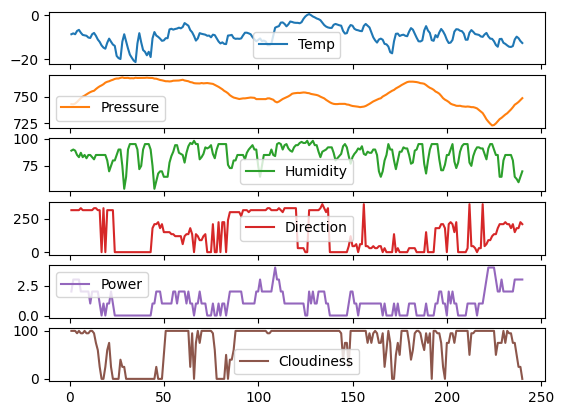

In [11]:
plot_cols = ['Temp', 'Pressure', 'Humidity','Direction', 'Power', 'Cloudiness']

plot_features = df[plot_cols][:240]
plot_features.index = df.index[:240]
_ = plot_features.plot(subplots=True)

Выведем статистику по данным за все время: <i>количество строк</i>, <i>среднее значение</i>, <i>ср. кв. отклонение</i>, <i>минимум </i>и <i>максимум</i>

In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,53071.0,2013.674417,5.249870,2005.0,2009.0,2014.0,2018.0,2023.0
Month,53071.0,6.486066,3.453460,1.0,3.0,6.0,9.0,12.0
Day,53071.0,15.720205,8.801121,1.0,8.0,16.0,23.0,31.0
Hour,53071.0,10.500198,6.873842,0.0,6.0,12.0,16.5,21.0
Temp,53071.0,6.719966,10.819880,-30.5,-0.8,6.4,15.2,37.8
Pressure,53071.0,747.566790,7.567347,712.2,742.9,747.5,752.2,778.2
Humidity,53071.0,75.996947,17.735161,12.0,65.0,81.0,90.0,100.0
Direction,53071.0,144.520171,117.410968,0.0,0.0,135.0,240.0,360.0
Power,53071.0,1.166381,0.951122,0.0,0.0,1.0,2.0,8.0
Cloudiness,53071.0,70.953628,38.003324,0.0,40.0,95.0,100.0,100.0


Поскольку о данных ветра не совсем удобно судить по такой статистике, то проще представить ее в виде <b>розы ветров</b>. Для этого создадим вектор ветра, но для начала покажем график распределения ненулевых значений ветра

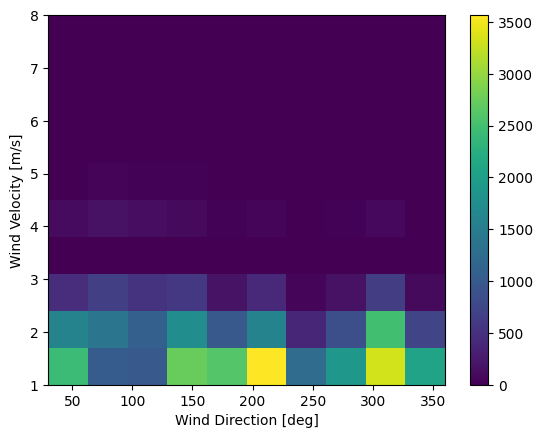

In [13]:
df_filter = df[df['Direction'] != 0.0].copy()

plt.hist2d(df_filter['Direction'], df_filter['Power'])
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')
plt.show()

Далее создадим <b>вектор</b> ветра, чтобы проще интерпретировать модель/

In [17]:
wv = df_filter['Power']
max_wv = df_filter['Power'].max()
wd_rad = df_filter['Direction']*np.pi/180

df_filter.loc[:, 'Wx'] = wv * np.cos(wd_rad)
df_filter.loc[:, 'Wy'] = wv * np.sin(wd_rad)

df_filter.head(10)

,Year,Month,Day,Hour,Temp,Pressure,Humidity,Direction,Power,Cloudiness,Weather,LowCl,LowPerc,Height,HighCl1,HighCl2,Visibility,Rainfall,Wx,Wy
1,2005,2,1,3,-8.6,743.0,89.0,315.0,2.0,100.0,Снег,Слоисто-кучевые,75.0,800.0,Высокослоистые просвечивающие.,"Перисто-кучевые одни или перисто-кучевые, сопр...",NaN,NaN,1.414214,-1.414214
2,2005,2,1,6,-8.2,742.8,90.0,315.0,3.0,100.0,Снег,Слоистые разорванные или кучевые разорванные о...,75.0,450.0,Высокослоистые просвечивающие.,"Перисто-кучевые одни или перисто-кучевые, сопр...",NaN,2,2.121320,-2.121320
3,2005,2,1,9,-8.6,743.5,89.0,315.0,3.0,100.0,Снег,Слоистые разорванные или кучевые разорванные о...,100.0,450.0,Высокослоистые просвечивающие.,"Перисто-кучевые одни или перисто-кучевые, сопр...",4,3,2.121320,-2.121320
4,2005,2,1,12,-7.1,745.0,85.0,315.0,3.0,95.0,Снег,Слоисто-кучевые,95.0,800.0,NaN,NaN,10,NaN,2.121320,-2.121320
5,2005,2,1,15,-6.6,746.8,83.0,315.0,3.0,100.0,Ливень,Кучевые средние,100.0,450.0,Высококучевые башенкообразные или хлопьевидные.,"Перисто-кучевые одни или перисто-кучевые, сопр...",4,NaN,2.121320,-2.121320
6,2005,2,1,18,-7.9,748.7,87.0,330.0,2.0,95.0,Снег,Слоисто-кучевые,95.0,800.0,NaN,NaN,NaN,NaN,1.732051,-1.000000
7,2005,2,1,21,-8.9,750.0,83.0,315.0,2.0,95.0,Снег,Слоисто-кучевые,95.0,800.0,NaN,NaN,NaN,1,1.414214,-1.414214
8,2005,2,2,0,-9.1,751.0,85.0,315.0,2.0,100.0,Снег,Слоистые разорванные или кучевые разорванные о...,75.0,450.0,NaN,"Перисто-кучевые одни или перисто-кучевые, сопр...",NaN,NaN,1.414214,-1.414214
9,2005,2,2,3,-9.3,752.2,82.0,315.0,2.0,95.0,Состояние неба не изменилось,Слоисто-кучевые,95.0,800.0,NaN,NaN,NaN,NaN,1.414214,-1.414214
10,2005,2,2,6,-10.1,753.3,85.0,315.0,2.0,95.0,Снег,Слоисто-кучевые,95.0,800.0,NaN,NaN,NaN,0.4,1.414214,-1.414214


А здесь уже представим его на графике,выберем количество точек <i>20x20</i> так как при этом достигается минимальная плотность расставления векторов

(-5.0, 4.330127018922194, -8.0, 7.0)

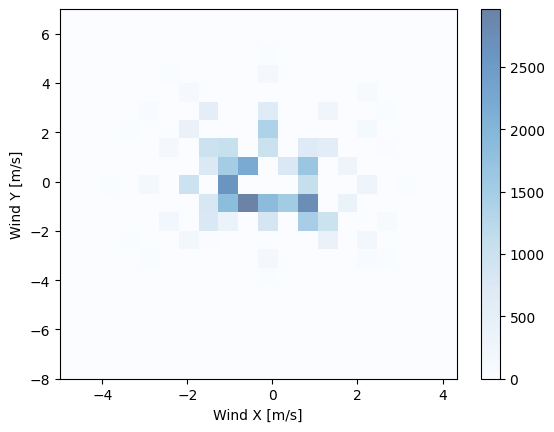

In [15]:
plt.hist2d(df_filter['Wx'], df_filter['Wy'], bins=(20, 20), alpha=0.6, cmap='Blues')
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

Давайте наложим эту карту ветров на карту местности, чтобы понять откуда дует :)

Изобразим розу ветров для точки на ВДНХ

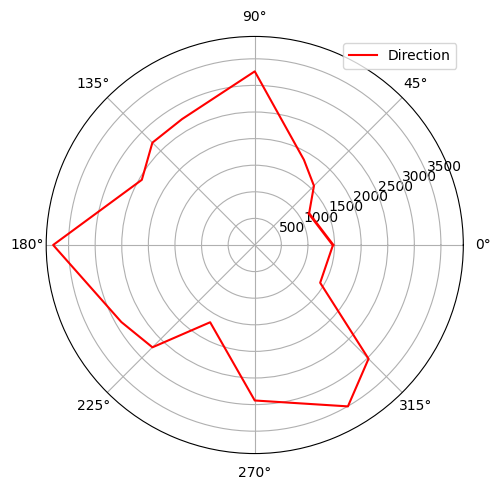

In [16]:
fig = plt.figure(figsize=(10, 5))

total_counts = df_filter['Direction'].value_counts()
angles = df_filter['Direction'].value_counts().index

sort_ang = np.sort(angles)
sorted_counts = total_counts.loc[sort_ang]
sort_ang = total_counts.loc[sort_ang].index * (2*np.pi / 360)

ax = fig.add_subplot(111, projection='polar')
ax.plot(sort_ang, sorted_counts, color='r', label='Direction') 
ax.plot((sort_ang[-1], sort_ang[0]), (sorted_counts.iloc[-1], sorted_counts.iloc[0]), color='r', linewidth=2)

ax.legend()

plt.tight_layout()
plt.show()

Найдем на карте мира Москву, а конкретно ВДНХ. Расположим точку cham_lon и cham_lat на координатах станции, и наложим розу ветров конкретно на точку измерения

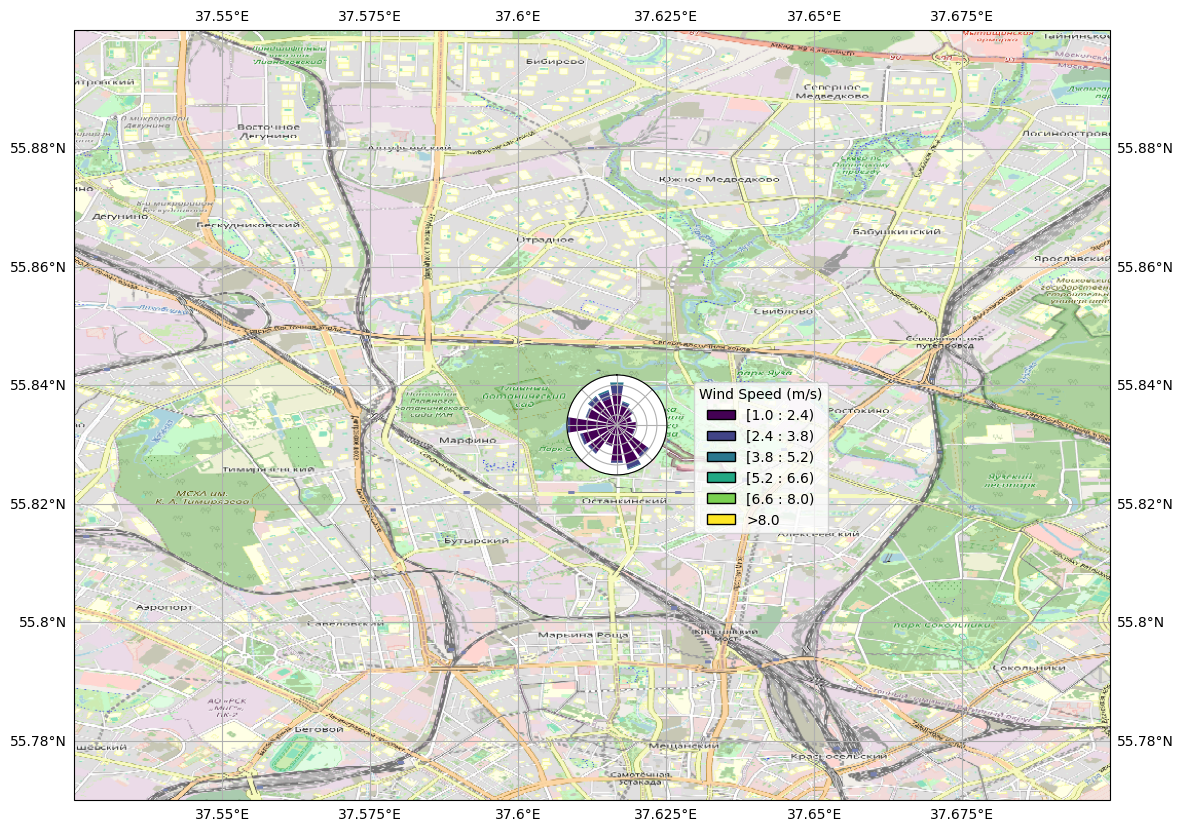

In [18]:
minlon, maxlon, minlat, maxlat = (37.525, 37.7, 55.77, 55.9)

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(15, 10))

main_ax = fig.add_subplot(1, 1, 1, projection=proj)
main_ax.set_extent([minlon, maxlon, minlat, maxlat], crs=proj)
main_ax.gridlines(draw_labels=True)
main_ax.coastlines()

request = cimgt.OSM()
main_ax.add_image(request, 13)

cham_lon, cham_lat = (37.616667, 55.833333)

wrax_cham = inset_axes(main_ax,
        width=1,                            
        height=1,                            
        loc='center',                        
        bbox_to_anchor=(cham_lon, cham_lat), 
        bbox_transform=main_ax.transData,    
        axes_class=windrose.WindroseAxes,    
        )

wrax_cham.set_theta_offset( np.pi /2)
wrax_cham.set_theta_direction(-1)

wrax_cham.bar(df_filter['Direction'],df_filter['Power'])
legend = wrax_cham.legend(title='Wind Speed (m/s)', loc='best', bbox_to_anchor=(1.2, 1))

for ax in [wrax_cham]:
  ax.tick_params(labelleft=False, labelbottom=False)

Построим график изменения среднемесячной температуры за последние несколько лет, для этого с помощью SQL запроса посчитаем среднемесячную температуру месяца

In [ ]:
monthly_avg_temps = ps.sqldf("""SELECT Year, Month, AVG(Temp)
                    FROM df 
                    GROUP BY Year,Month"""
               ,locals())
monthly_avg_temps

И выведем начиная с 2005 года до 2024 года с шагом в 3, чтобы наша диаграмма являлась легкочитаемой

In [ ]:
years = [year for year in range(2005,2024,3)]
fig, ax = plt.subplots(figsize=(8, 6))

for year in years:
    yearly_data = monthly_avg_temps[monthly_avg_temps['Year'] == year]
    if not yearly_data.empty:
        ax.plot(yearly_data['Month'], yearly_data['AVG(Temp)'], label=f'Year {year}')

ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('Month')
ax.legend()
ax.grid(True)
ax.set_xticks(np.arange(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()
plt.show()

И тут под песню Иванушек интернешнл можно понять что за 20 лет температура так и колебалась около своих медианных значений.

Итак пришла пора проверить более интересные вещи, например русские пословицы и поговорки. Итак приведем некоторые из них:
- <b> Про сезонность </b> : <i> Лето жаркое - зима морозная.</i>
- <b> Про погоду </b> : <i>Если дождь пошёл с обеда - затянется на сутки.</i>


In [ ]:
def get_winter_year(row):
    if row['Month'] == 12:
        return row['Year'] + 1
    return row['Year']

df['Winter_Year'] = df.apply(get_winter_year, axis=1)

avg_temps_smmr = ps.sqldf("""SELECT Year, AVG(Temp)
                    FROM df 
                    WHERE Month = 6 or Month = 7 or Month = 8
                    GROUP BY Year"""
               ,locals())

avg_temps_wntr = ps.sqldf("""SELECT Year, AVG(Temp)
                    FROM df 
                    WHERE Month = 12 or Month = 1 or Month = 2
                    GROUP BY Year"""
               ,locals())

merged_temps = pd.merge(avg_temps_smmr, avg_temps_wntr, on='Year')

print(merged_temps)

correlation = merged_temps['AVG(Temp)_y'].corr(merged_temps['AVG(Temp)_x'])

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot([year for year in range(2005,2023)], merged_temps['AVG(Temp)_x'])
ax.plot([year for year in range(2005,2023)], merged_temps['AVG(Temp)_y'])

ax.set_ylabel('Year')
ax.set_xlabel('Temperature')
ax.grid(True)
plt.show()

print("Коэффициент корреляции между средней температурой летом и зимой:", correlation)

Отсюда можно судить что кореляция является умеренно отрицательной. Что можно представить как частичное выполнение нашей гипотезы: действительно при увеличении температуры летом, температура зимой скорее всего будет пониженной. :)

Теперь проверим другую поговорку связанную с началом дождя в обед, для этого выведем дни когда дождь начался именно в обед, и не шел с утра. Обед у каждого разный, поэтому напишем что он где-то в 12 и 15 часов, а для проверки условий начала дождя достаточно проверить два предыдущих временных отрезка в 6 и 9 часов.

In [ ]:
rain_days = ps.sqldf("""SELECT df.Year, df.Month, df.Day, COUNT(*)
            FROM df 
            LEFT JOIN  (SELECT Year, Month, Day, COUNT(*) AS CNT
                        FROM df 
                        WHERE (Weather!='Дождь' and Weather!='Ливень' and Weather!='Морось') and  (Hour = 6 or Hour = 9)
                        GROUP BY Year, Month, Day) as total
            ON df.Year=total.Year AND df.Month=total.Month AND df.Day=total.Day
            WHERE (Weather='Дождь' or Weather='Ливень' or Weather='Морось') and (df.Hour = 12 or df.Hour = 15) and total.CNT=2
            GROUP BY df.Year, df.Month, df.Day"""
           ,locals())

rain_days = pd.to_datetime(rain_days[['Year', 'Month', 'Day']])
rain_days

И теперь для полученных дней надо проверить сколько шел дальше дождь подряд часов и посчитаем его среднюю продолжительность 


In [ ]:
def calculate_rain_duration(df, start_date):
    start_date_12 = pd.Timestamp(year=start_date.year, month=start_date.month, day=start_date.day, hour=12)
    mask = (df['Date'] >= start_date_12)
    sub_df = df.loc[mask]

    rain_mask = (sub_df['Weather'] == 'Дождь') | (sub_df['Weather'] == 'Состояние неба не изменилось') | (sub_df['Weather'] == 'Морось') | (sub_df['Weather'] == 'Ливень')
    rain_df = sub_df.loc[rain_mask]

    current_duration = 3
    i=0
    while (rain_df.iloc[i+1]['Date'] == rain_df.iloc[i]['Date'] + pd.Timedelta(hours=3)):
        current_duration += 3
        i += 1
    return current_duration
    
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])
durations = [calculate_rain_duration(df, date) for date in rain_days]

count = 0
h_sum = 0.0

for duration in durations:
    h_sum += duration
    count += 1
    
print('Cредняя продолжительность дождя: ', h_sum/count)
print('Медианная продолжительность дождя: ', np.median(np.sort(durations)))

Получается что и тут немного не корректно, что если в обед начался дождь, то примерно он продлится ~7 часов, а не сутки как в гипотезе  :/

Зато вместо этого можно представить свою поговорку: <i> Если дождь начался в обед, то он продлится до вечера. </i>

<h2>Предсказательная модель</h2>

Перейдем к предскательной модели и попробуем на основе них предсказать некоторые атрибуты нашего набора. Для начала покажем наиболее важные характеристики частоты.

In [ ]:
fft = tf.signal.rfft(df['Temp'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['Temp'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency')

df.head()

Перед обучением нейронной сети происходит масштабирование функции. Нормализация - популярный способ масштабировать, для этого вычтем среднее значение и разделим на стандартное отклонение каждого признака и скопируем в другой датафрейм

In [ ]:
timestamp_s = df['Date'].map(pd.Timestamp.timestamp)
day = 24*60*60
year = 365.2425 * day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

df_std = df

features_to_normalize = ['Temp', 'Pressure', 'Humidity', 'Direction', 'Power', 'Cloudiness']
scaler = StandardScaler()
df_std[features_to_normalize] = scaler.fit_transform(df_std[features_to_normalize])

df_std.head(3)

Раскатегоризируем столбец погоды под модель

In [ ]:
enc = OneHotEncoder()
df_std = df_std.reset_index(drop=True)
df_std_categorized = pd.DataFrame(enc.fit_transform(df_std[['Weather']]).toarray())
encoded_columns = enc.get_feature_names_out(['Weather'])
df_std_categorized.columns = encoded_columns
df_std = df_std[['Temp', 'Pressure', 'Humidity', 'Direction', 'Power', 'Cloudiness']].join(df_std_categorized)
df_std.head(3)

Методом Random Forest определим важность других признаков в определении температуры

In [ ]:
X = df_std.drop(columns=['Temp']) 
y = df_std['Temp']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

feature_importances = model.feature_importances_

features = X.columns
importances = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importances = importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title('Feature Importances')
plt.show()

Получили что влажность и давление являются важнейшими признаками в определении температурных условий, как не странно снежная погода также влияет на температуру в течении дня :)

Спрогнозируем на основе тренировочных и проверочных данных нашу модель, разделим на 70% и 20% нашу базу данных и с помощью метрик MSE и R2 оценим нашу модель

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print('Validation MSE: ',val_mse)
print('Validation R2: ',val_r2)

y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('Test MSE: ', test_mse)
print('Test R2: ', test_r2)

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Temperatures')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

Получим что среднеквадратичная ошибка в пределах от 65 до 70, а коэффициент детерминации колеблется около значений 0.43-0.45, что является большой ошибкой для предсказания, попробуем другие регрессии. 

Например модель <i>линейной регрессии</i>:

In [ ]:
linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

y_val_pred_linear = linear_model.predict(X_val)
y_test_pred_linear = linear_model.predict(X_test)

val_mse_linear = mean_squared_error(y_val, y_val_pred_linear)
val_r2_linear = r2_score(y_val, y_val_pred_linear)
test_mse_linear = mean_squared_error(y_test, y_test_pred_linear)
test_r2_linear = r2_score(y_test, y_test_pred_linear)

print('Linear Regression Validation MSE: ', val_mse_linear)
print('Linear Regression Validation R2: ', val_r2_linear)
print('Linear Regression Test MSE: ', test_mse_linear)
print('Linear Regression Test R2: ', test_r2_linear)


Получилось несколько хуже, коэффициент детерминации уже меньше, поэтому модель хуже объясняет изменчивость переменной. 

Модель <i>нейронной сети:</i>:

In [ ]:
mlp_model = MLPRegressor(random_state=42)

mlp_model.fit(X_train, y_train)

y_val_pred_mlp = mlp_model.predict(X_val)
y_test_pred_mlp = mlp_model.predict(X_test)

val_mse_mlp = mean_squared_error(y_val, y_val_pred_mlp)
val_r2_mlp = r2_score(y_val, y_val_pred_mlp)
test_mse_mlp = mean_squared_error(y_test, y_test_pred_mlp)
test_r2_mlp = r2_score(y_test, y_test_pred_mlp)

print('MLP Regression Validation MSE: ', val_mse_mlp)
print('MLP Regression Validation R2: ', val_r2_mlp)
print('MLP Regression Test MSE: ', test_mse_mlp)
print('MLP Regression Test R2: ', test_r2_mlp)


Получилось лучше, коэффициент детерминации R2 уже наибольший, поэтому модель наиболее хорошо описывает поведение регрессии